In [1]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

plaq = plaq12
L = plaq['L']
# basis = spin_basis_1d(L, pauli=0, Nup=(5, 6, 7))
basis = spin_basis_1d(L, pauli=0)


ops = hmf.operators.mf_ops(plaq, basis)
maxit = 50

# Sublattice magnetizations
Many magnetic observables on this lattice are constructed from sublattice magnetization, i.e. $m_l^x = \sum_{i\in l} \sigma_i^x$ for one of the three sublattices of next-nearest neighbors.

In [2]:
A, B, C = plaq['n_nearest_sublattice']
sl_mag_ops = {'A': {}, 'B': {}, 'C': {}}

dirs = ['x', 'y', 'z']
sls = {'A': A, 'B': B, 'C': C}
for d in dirs:
    for sl in sls:
        op_lst = [[d, [[1, i] for i in sls[sl]]]]
        sl_mag_ops[sl][d] = quantum_operator({'static': op_lst}, basis=basis)
        
def get_mags(v, sl_ops, ind, mag_array, mag_2_array, mag_4_array):
    mags ={'A': {}, 'B': {}, 'C': {}}
    for d in dirs:
        for sl in sls:
            mag_array[sl][d][ind] = np.real(sl_ops[sl][d].expt_value(v))
            m2v = sl_ops[sl][d].dot(sl_ops[sl][d].dot(v))
            mag_2_array[sl][d][ind] = np.real(np.vdot(v, m2v))
            mag_4_array[sl][d][ind] = np.real(np.vdot(v, sl_ops[sl][d].dot(sl_ops[sl][d].dot(m2v))))

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


# Balence bond observables
What if we look for some structure of singlet pairs.
First off, let's look at a triangle

          2
         / \
        0 - 1
  
and measure 
\begin{equation}
B_\triangle = \langle {\sigma_0\cdot \sigma_1 + \sigma_1\cdot \sigma_2 + \sigma_2\cdot\sigma_0}\rangle.
\end{equation}
We can also draw a lozenge

          2 - 3
         / \ / 
        0 - 1
        
and measure
\begin{equation}
B_\lozenge^x = \langle {\sigma_0\cdot \sigma_1 + \sigma_2\cdot \sigma_3\rangle},
\quad
B_\lozenge^y = \langle {\sigma_0\cdot \sigma_2 + \sigma_1\cdot \sigma_3\rangle},
\end{equation}
where $x$ and $y$ refer to the horizontal and diagonal up/right lattice vectors the singlets form across.

Why not just use the thing other people use? Specifically, how about we sum over a bond (type $\alpha$). I don't want to make a formula right now, so let's go to something concrete.

In our 12-site plaquette, the sites are indexed as 
   
       10 -11
       / \ / \ 
      7 - 8 - 9
     / \ / \ / \ 
    3 - 4 - 5 - 6
     \ / \ / \ /
      0 - 1 - 2
      
For now, I'll compute $B_\triangle$ on the triangle formed by sites 4-5-8 and $B_\lozenge$ on the lozenge formed by sites 4-5-9-8. Theoretically, there are three kinds of triangle (fully enclosed, one site on the border, and two sites on the border) and two kinds of lozenge (none are fully enclosed).

Let's call the bond directions `-`, `/`, and `\` $x$, $y$, and $z$ respectively.

In [3]:
op_lst = [['xx', [[1, 4, 5], [1, 5, 8], [1, 8, 4]]],
          ['yy', [[1, 4, 5], [1, 5, 8], [1, 8, 4]]],
          ['zz', [[1, 4, 5], [1, 5, 8], [1, 8, 4]]],
         ]
b_tri_op = quantum_operator({'static': op_lst}, basis=basis)

op_lst = [['xx', [[1, 4, 5], [1, 8, 9]]],
          ['yy', [[1, 4, 5], [1, 8, 9]]],
          ['zz', [[1, 4, 5], [1, 8, 9]]],
         ]
bx_op = quantum_operator({'static': op_lst}, basis=basis)

op_lst = [['xx', [[1, 4, 8], [1, 5, 9]]],
          ['yy', [[1, 4, 8], [1, 5, 9]]],
          ['zz', [[1, 4, 8], [1, 5, 9]]],
         ]
by_op = quantum_operator({'static': op_lst}, basis=basis)

def get_vbs(v, vb_array, ind):
    vb_array['x'][ind] = np.real(np.vdot(v, bx_op.dot(bx_op.dot(v))))
    vb_array['y'][ind] = np.real(np.vdot(v, by_op.dot(by_op.dot(v))))
    vb_array['t'][ind] = np.real(np.vdot(v, b_tri_op.dot(b_tri_op.dot(v))))

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


# Scalar chiralities

We can also look at scalar chiralities within triangles. Let's do it this way:
on an upright triangle

      2
     / \
    0 - 1

we can measure 
\begin{equation}
\chi = \sigma_2\cdot(\sigma_0\times \sigma_1)
=\sigma_2^x (\sigma_0^y\sigma_1^z - \sigma_0^z \sigma_1^y)
+ \sigma_2^y (\sigma_0^z\sigma_1^x - \sigma_0^x \sigma_1^z)
+ \sigma_2^z (\sigma_0^x\sigma_1^y - \sigma_0^y \sigma_1^x)
\end{equation}

On an upside-down triangle

    1 - 2
     \ / 
      0

we can measure 
\begin{equation}
\chi = \sigma_0 \cdot(\sigma_2\times \sigma_1)
=\sigma_0^x (\sigma_2^y\sigma_1^z - \sigma_2^z \sigma_1^y)
+ \sigma_0^y (\sigma_2^z\sigma_1^x - \sigma_2^x \sigma_1^z)
+ \sigma_0^z (\sigma_2^x\sigma_1^y - \sigma_2^y \sigma_1^x)
\end{equation}
Again, our cluster is

   
       10 -11
       / \ / \ 
      7 - 8 - 9
     / \ / \ / \ 
    3 - 4 - 5 - 6
     \ / \ / \ /
      0 - 1 - 2

In [33]:
urts = [[4,0,1],
        [5,1,2],
        [7,3,4],
        [8,4,5],
        [9,5,6],
        [10,7,8],
        [11,8,9]]

dwts = [[0,3,4],
        [1,4,5],
        [2,5,6],
        [4,7,8],
        [5,8,9],
        [8,10,11]]

def scalar_chirality(sites, basis):
    a, b, c = sites
    op_lst = [['xyz', [[1, a, b, c], [-1, a, c, b]]],
              ['yzx', [[1, a, b, c], [-1, a, c, b]]],
              ['zxy', [[1, a, b, c], [-1, a, c, b]]],
             ]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)

urt_ops = [scalar_chirality(sites, basis) for sites in urts]
dwt_ops = [scalar_chirality(sites, basis) for sites in dwts]

def get_chis(v, urt_array, dwt_array, ind):
    for i in range(7):
        urt_array[ind, i] = np.real(urt_ops[i].expt_value(v))
        if i != 6:
            dwt_array[ind, i] = np.real(dwt_ops[i].expt_value(v))

# Helicities?

What about (on the same upright triangles)
\begin{equation}
H_\alpha = \left(\sigma_0\times \sigma_1 + \sigma_1\times \sigma_2 + \sigma_2\times\sigma_0\right)_\alpha
\end{equation}

In [34]:
def z_chirality(sites, basis):
    a, b, c = sites
    op_lst = [['xy', [[1, a, b], [-1, b, a],
                      [1, b, c], [-1, c, b],
                      [1, c, a], [-1, a, c],
                     ]],
             ]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)

urt_z_ops = [z_chirality(sites, basis) for sites in urts]
dwt_z_ops = [z_chirality(sites, basis) for sites in dwts]

def get_z_chis(v, urt_array, dwt_array, ind):
    for i in range(7):
        urt_array[ind, i] = np.real(urt_ops[i].expt_value(v))
        if i != 6:
            dwt_array[ind, i] = np.real(dwt_ops[i].expt_value(v))

# Energy and observables

Let's calculate energy going left to right and right to left using HMFT.

In [5]:
J2s = np.linspace(0, 0.3, 40)

l = len(J2s)
labels = ['inner', 'periodic', 'lr', 'rl']
energies = {lab: np.zeros(l) for lab in labels}
mfs = {lab: [None for i in range(l)] for lab in labels}
cvgs = {lab: np.zeros(l) for lab in labels}

sl_mags = {lab: {s: {d: np.zeros(l) for d in dirs} for s in sls} for lab in labels}
sl_4_mags = {lab: {s: {d: np.zeros(l) for d in dirs} for s in sls} for lab in labels}
sl_2_mags = {lab: {s: {d: np.zeros(l) for d in dirs} for s in sls} for lab in labels}

urt_chis = {lab: np.zeros((l, 7)) for lab in labels}
dwt_chis = {lab: np.zeros((l, 6)) for lab in labels}


vbs = {lab: {'x': np.zeros(l), 'y': np.zeros(l), 't': np.zeros(l)} for lab in labels}


In [35]:
mf0 = None
print('Running left to right')

for i, J2 in enumerate(tqdm(J2s)):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': 0},
                    'n_n_nearest': {}}
    Hi = inner_hamiltonian(plaq, interactions, basis, every_other=True)
    e, v = Hi.eigsh(k=1, which='SA', tol=10**-12)
    energies['inner'][i] = e[0]
    get_mags(v[:,0], sl_mag_ops, i, 
             sl_mags['inner'], sl_2_mags['inner'], sl_4_mags['inner'])
    get_vbs(v[:,0], vbs['inner'], i)
    get_z_chis(v[:,0], urt_chis['inner'], dwt_chis['inner'], i)
    
    
    Hp = periodic_hamiltonian(plaq, interactions, basis, every_other=True)
    e, v = Hp.eigsh(k=1, which='SA', tol=10**-12)
    energies['periodic'][i] = e[0]
    get_mags(v[:,0], sl_mag_ops, i, 
             sl_mags['periodic'], sl_2_mags['periodic'], sl_4_mags['periodic'])
    get_vbs(v[:,0], vbs['periodic'], i)
    get_z_chis(v[:,0], urt_chis['periodic'], dwt_chis['periodic'], i)
    energies['lr'][i], v, mfs['lr'][i], cvgs['lr'][i] = do_hmft(plaq, interactions, basis, 
                                                                max_iter=maxit, mf0=mf0, 
                                                                Hi=Hi,
                                                                ops=ops, hmft_tol=10**-8,
                                                                lanczos_tol=10**-11,
                                                                mf_cvg=False, every_other=True)
    mf0 = mfs['lr'][i]
    get_mags(v, sl_mag_ops, i, 
             sl_mags['lr'], sl_2_mags['lr'], sl_4_mags['lr'])
    get_vbs(v, vbs['lr'], i)
    get_z_chis(v, urt_chis['lr'], dwt_chis['lr'], i)




  0%|          | 0/40 [00:00<?, ?it/s]

Running left to right


100%|██████████| 40/40 [01:32<00:00,  2.32s/it]


In [36]:
    
print('Running right to left')
mf0 = None
for i, J2 in enumerate(tqdm(J2s[::-1])):
    j = l-1-i
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': 0},
                    'n_n_nearest': {}}
    energies['rl'][j], v, mfs['rl'][j], cvgs['rl'][j] = do_hmft(plaq, interactions, basis, 
                                                                max_iter=maxit, mf0=mf0, 
                                                                ops=ops, hmft_tol=10**-8,
                                                                lanczos_tol=10**-11,
                                                                mf_cvg=False, every_other=True)
    mf0 = mfs['rl'][j]
    get_mags(v, sl_mag_ops, j, 
             sl_mags['rl'], sl_2_mags['rl'], sl_4_mags['rl'])
    get_vbs(v, vbs['rl'], j)
    get_z_chis(v, urt_chis['rl'], dwt_chis['rl'], j)

  0%|          | 0/40 [00:00<?, ?it/s]

Running right to left


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


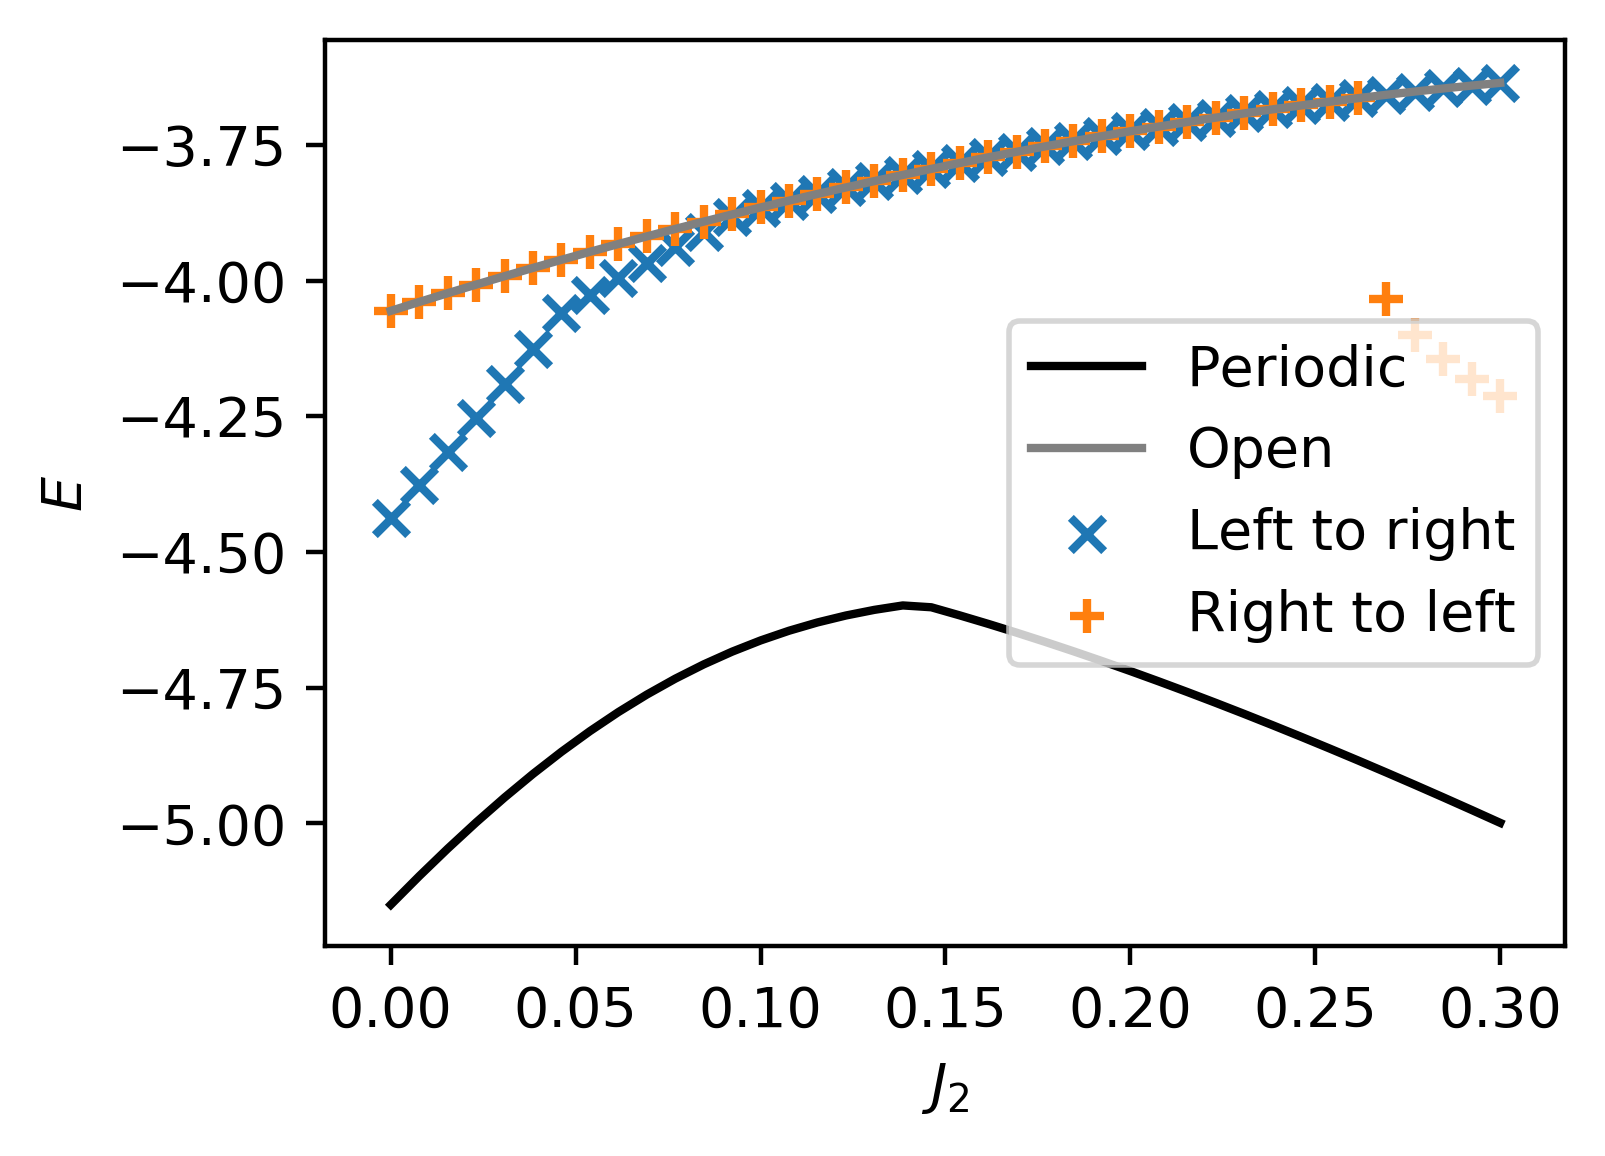

In [37]:
plt.figure(figsize=(4,3), dpi=400)
plt.scatter(J2s, energies['lr'], label='Left to right', marker='x')
plt.scatter(J2s, energies['rl'], label='Right to left', marker='+')
plt.plot(J2s, energies['periodic'], label='Periodic', color='black')
plt.plot(J2s, energies['inner'], label='Open', color='gray')
plt.xlabel('$J_2$')
plt.ylabel('$E$')
plt.legend()

Text(0, 0.5, '$d^2E/dJ_2^2$')

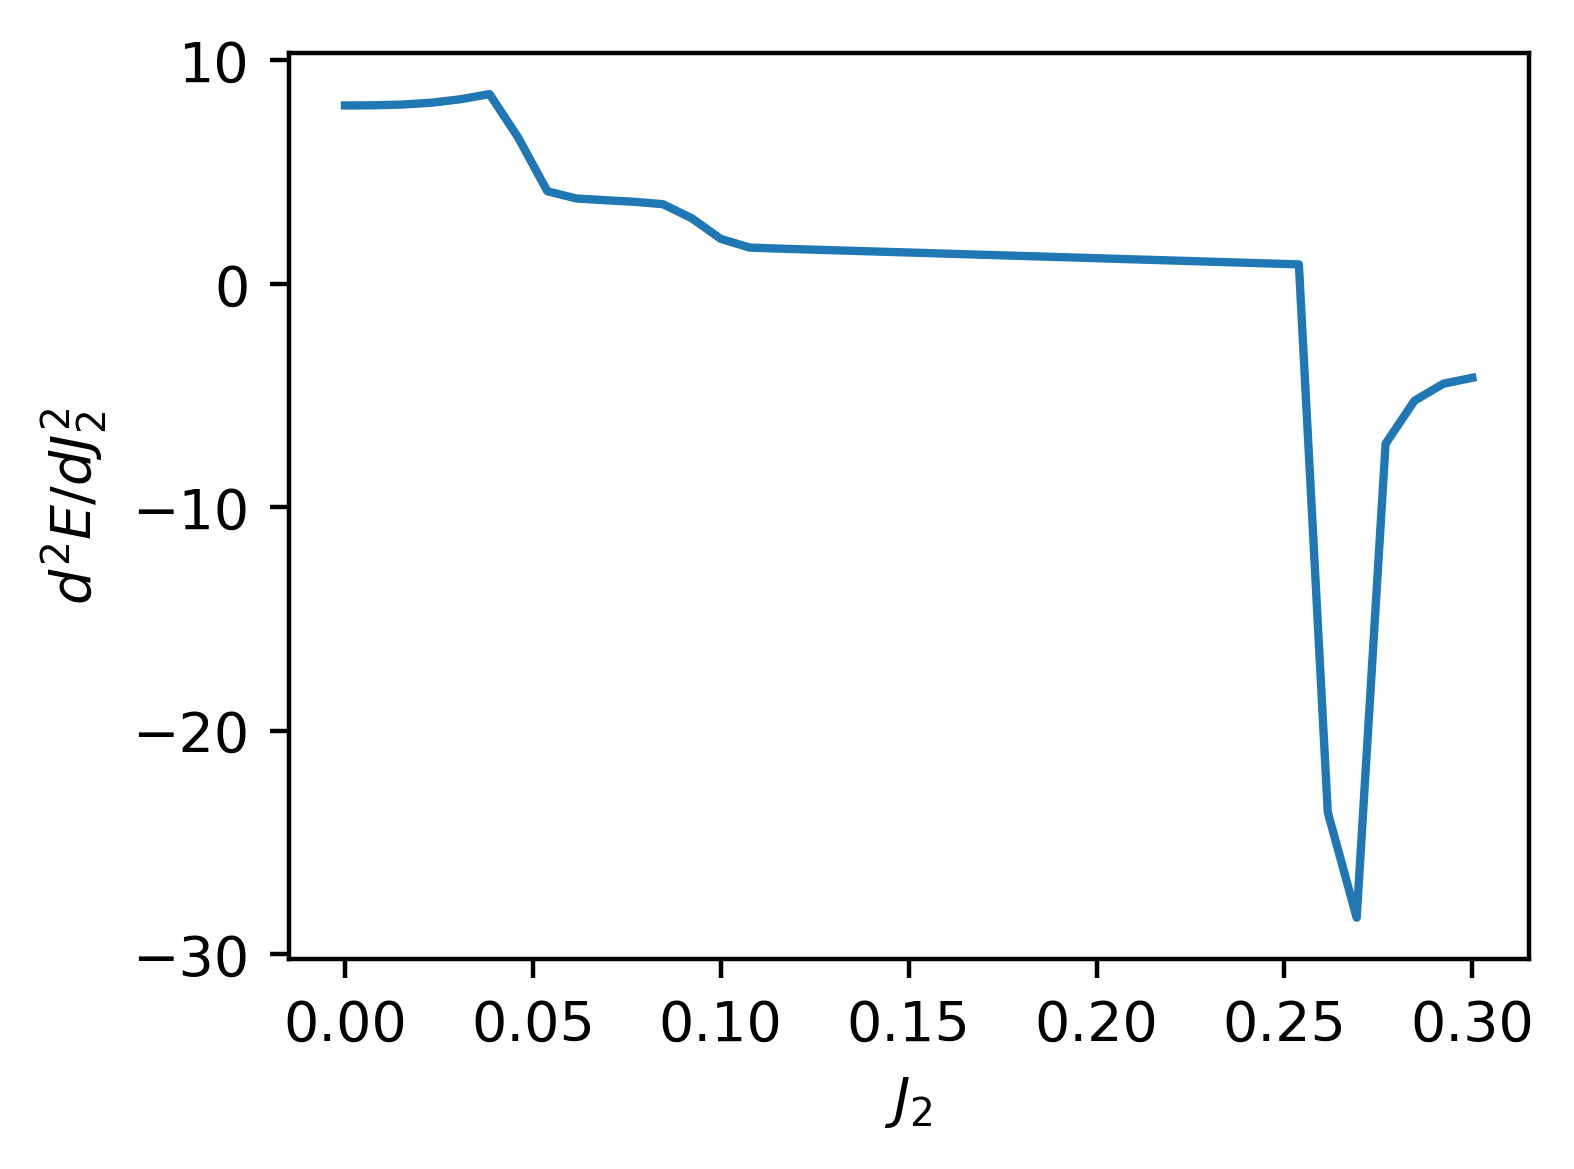

In [38]:
plt.figure(figsize=(4,3), dpi=400)
best_e = np.min((energies['rl'], energies['lr']), axis=0)
plt.plot(J2s, np.gradient(best_e, J2s))
plt.xlabel('$J_2$')
plt.ylabel(r'$d^2E/dJ_2^2$')
# plt.xlim(0, 0.2)
# plt.ylim(-350, 50)

(-350, 50)

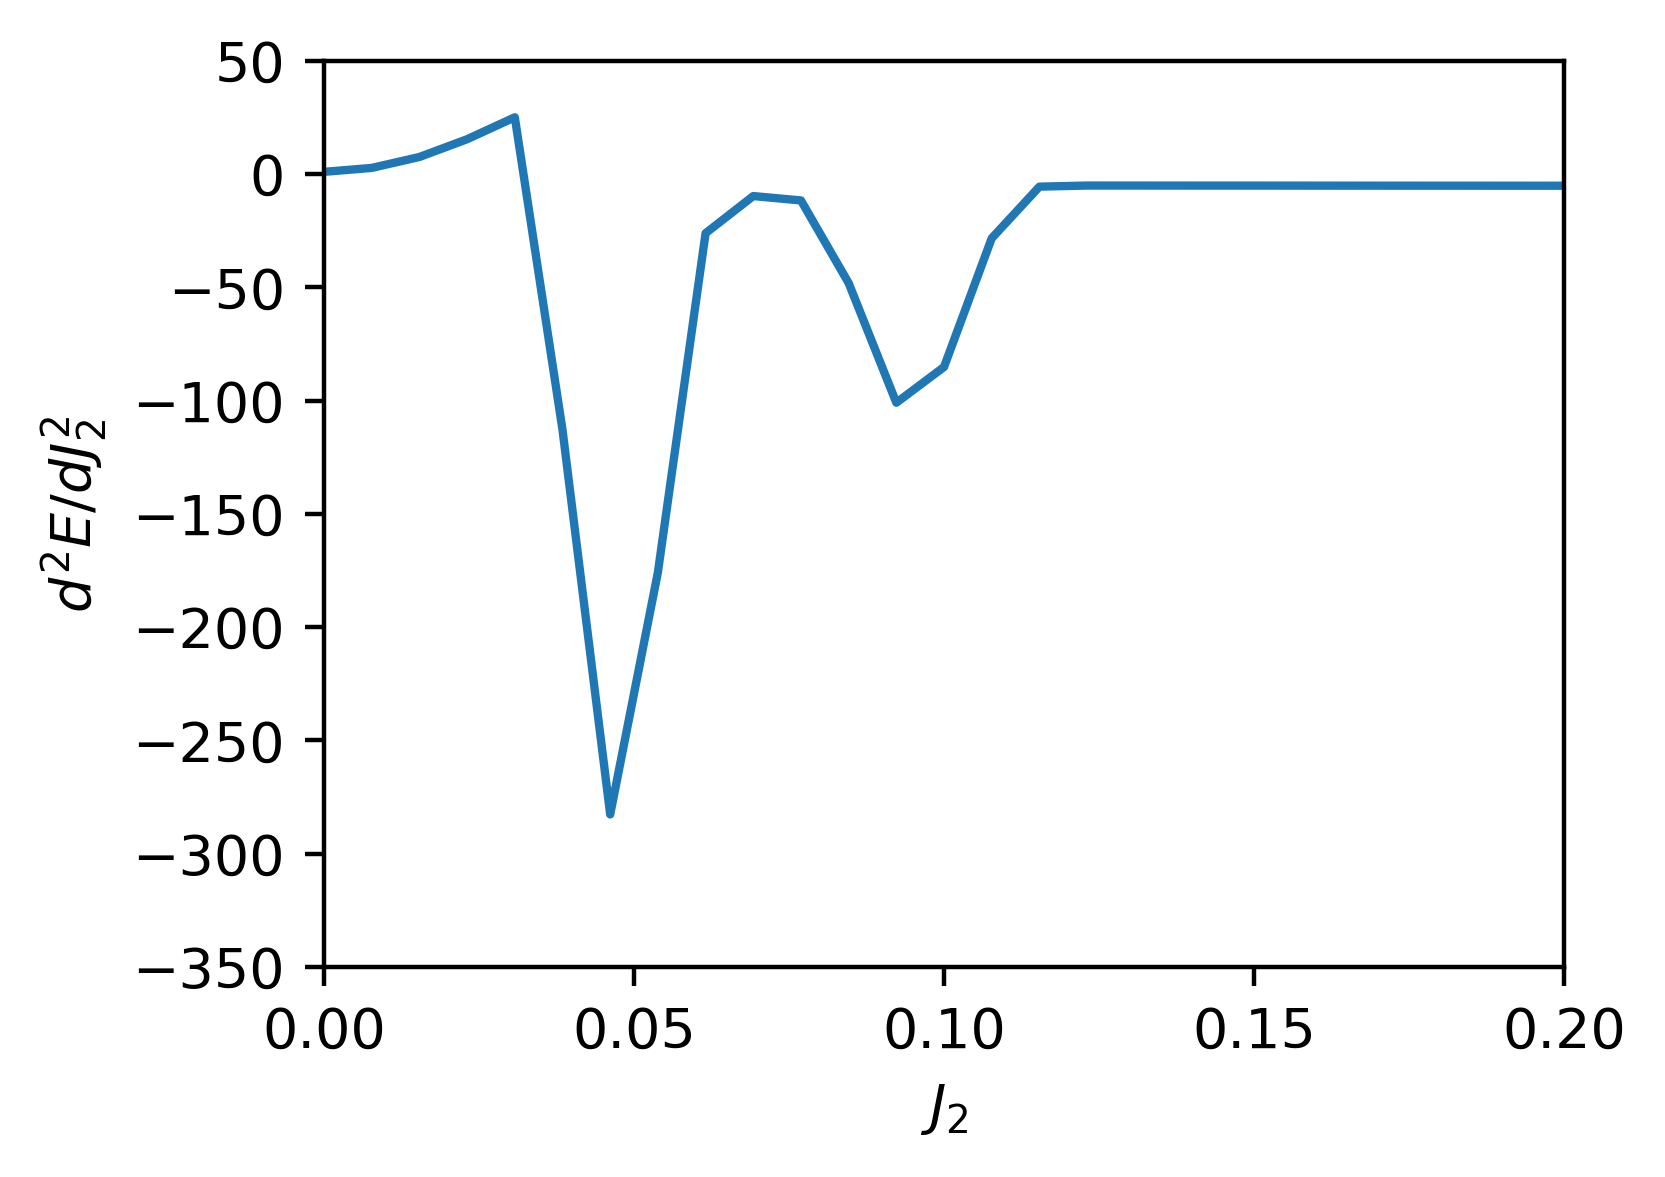

In [39]:
plt.figure(figsize=(4,3), dpi=400)
best_e = np.min((energies['rl'], energies['lr']), axis=0)
plt.plot(J2s, np.gradient(np.gradient(best_e, J2s), J2s))
plt.xlabel('$J_2$')
plt.ylabel(r'$d^2E/dJ_2^2$')
plt.xlim(0, 0.2)
plt.ylim(-350, 50)

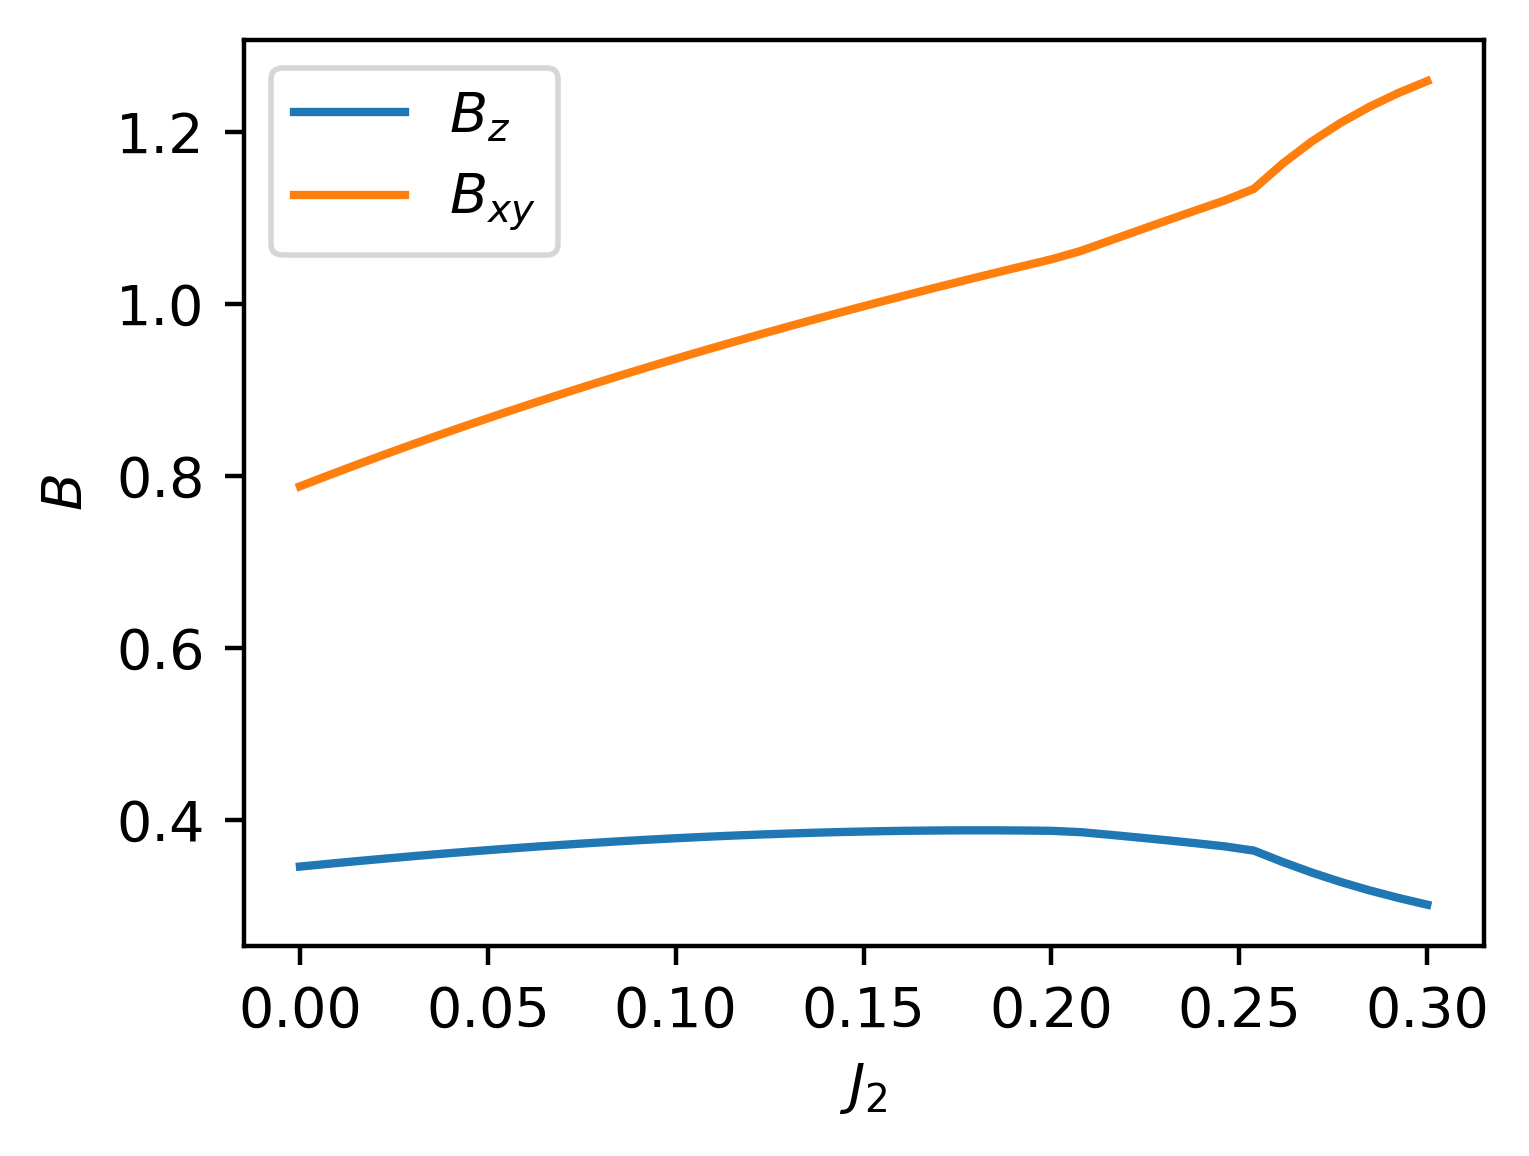

In [40]:
plt.figure(figsize=(4,3), dpi=400)
m2 = sl_2_mags['lr']
m4 = sl_4_mags['lr']
norm = 1./(4./6)**2

m2z = (m2['A']['z'] + m2['B']['z'] + m2['C']['z'])/3
m4z = (m4['A']['z'] + m4['B']['z'] + m4['C']['z'])/3
Bz = .5*(3-m4z/(m2z**2))

m2x = (m2['A']['x'] + m2['B']['x'] + m2['C']['x'])/3
m4x = (m4['A']['x'] + m4['B']['x'] + m4['C']['x'])/3
Bx = .5*(3-m4x/(m2x**2))

m2y = (m2['A']['y'] + m2['B']['y'] + m2['C']['y'])/3
m4y = (m4['A']['y'] + m4['B']['y'] + m4['C']['y'])/3
By = .5*(3-m4y/(m2y**2))

m2xy = (m2['A']['x'] + m2['B']['x'] + m2['C']['x'])/3
m2xy += (m2['A']['y'] + m2['B']['y'] + m2['C']['y'])/3
m4xy = (m4['A']['x'] + m4['B']['x'] + m4['C']['x'])/3
m4xy += (m4['A']['y'] + m4['B']['y'] + m4['C']['y'])/3
Bxy = .5*(5-3*m4xy/(m2xy**2))


plt.plot(J2s[::-1], Bz, label=r'$B_z$')
plt.plot(J2s[::-1], Bxy, label=r'$B_{xy}$')
# plt.plot(J2s[::-1], By, label=r'$B_y$')
plt.xlabel('$J_2$')
plt.ylabel('$B$')

plt.legend()

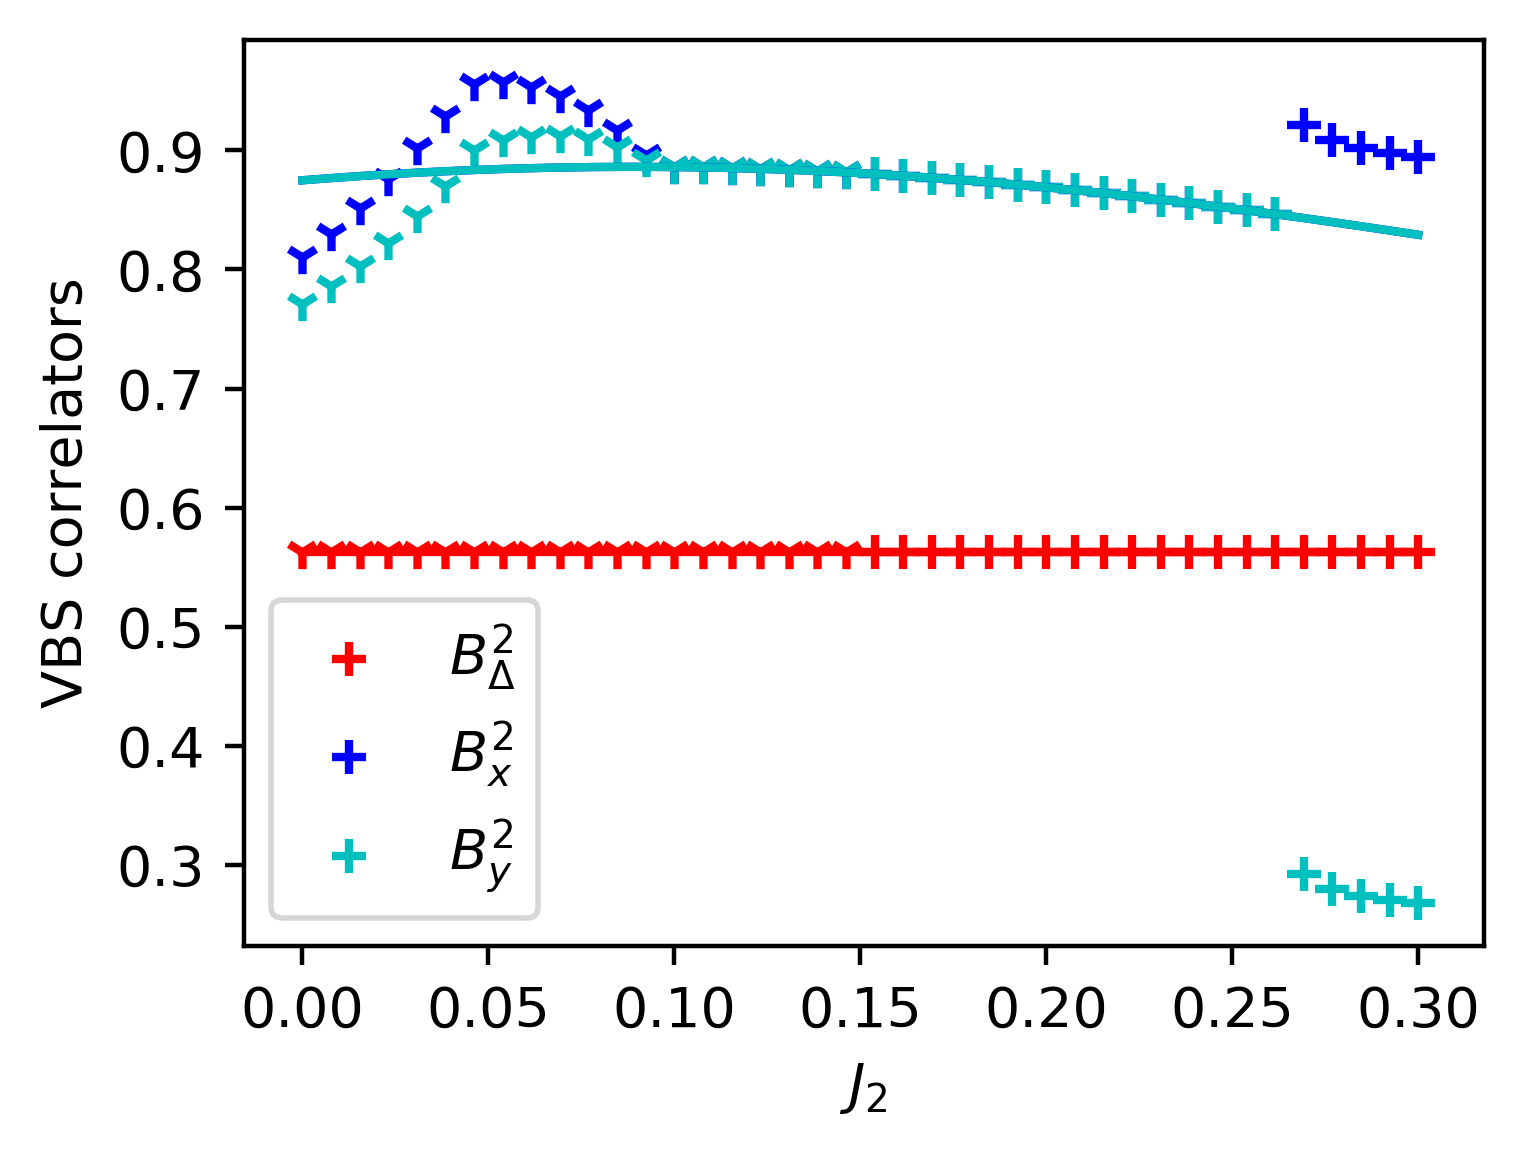

In [41]:
plt.figure(figsize=(4,3), dpi=400)

t_ind = np.argmin(np.abs(J2s-0.15))



plt.scatter(J2s[t_ind:], vbs['rl']['t'][t_ind:], label=r'$B_\Delta^2$', color='r', marker='+')
plt.scatter(J2s[t_ind:], vbs['rl']['x'][t_ind:], label=r'$B_x^2$', color='b', marker='+')
plt.scatter(J2s[t_ind:], vbs['rl']['y'][t_ind:], label=r'$B_y^2$', color='c', marker='+')

plt.scatter(J2s[:t_ind], vbs['lr']['t'][:t_ind], marker='1', color='r')
plt.scatter(J2s[:t_ind], vbs['lr']['x'][:t_ind], marker='1', color='b')
plt.scatter(J2s[:t_ind], vbs['lr']['y'][:t_ind],  marker='1', color='c')

plt.plot(J2s, vbs['inner']['t'], color='r')
plt.plot(J2s, vbs['inner']['x'], color='b')
plt.plot(J2s, vbs['inner']['y'], color='c')

plt.xlabel('$J_2$')
plt.ylabel('VBS correlators')

plt.legend()

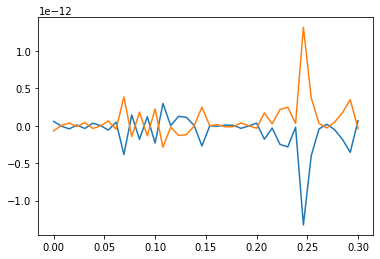

In [46]:
plt.plot(J2s, np.sum(dwt_chis['inner'], axis=1))
plt.plot(J2s, np.sum(urt_chis['inner'], axis=1))

# Long range spin-spin correlators

In [23]:
corr_inds = [[0, 4, 8, 11],
             [2, 5, 8, 10],
             [3, 4, 5, 6]]
def get_corrs(v, op_str, inds, basis):
    i0 = inds[0]
    corrs = np.zeros(len(inds)-1, dtype=np.complex128)
    for i, ind in enumerate(inds[1:]):
        print(ind)
        op = quantum_operator({'static': [[op_str, [[.5, i0, ind]]]]}, basis=basis, check_symm=False, check_herm=False)
        op += quantum_operator({'static': [[op_str[::-1], [[.5, i0, ind]]]]}, basis=basis, check_symm=False, check_herm=False)

        corrs[i] = op.expt_value(v)
    return corrs

-3.788051888457805
4
8
11
5
8
10
4
5
6


Text(0.5, 0, '$r$')

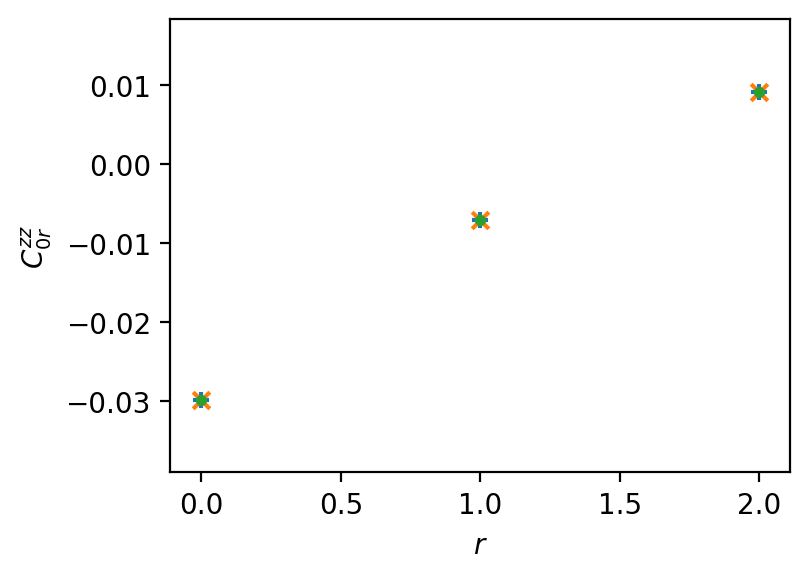

In [24]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .15, 'yy': .15, 'zz': 0},
                'n_n_nearest': {}}
markers = ['+', 'x', '.']
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=mf0, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
# Hi = periodic_hamiltonian(plaq, interactions, basis, every_other=True)
# e, v = Hi.eigsh(k=1, which='SA', tol=10**-12)
# v = v[:,0]
plt.figure(figsize=(4,3), dpi=200)
print(e)
for i, inds in enumerate(corr_inds):
    # print(inds)
    corrs = get_corrs(v, 'zz', inds, basis)
    plt.scatter(np.arange(3), np.real(corrs), marker=markers[i])
plt.ylabel(r'$C_{0r}^{zz}$')
plt.xlabel(r'$r$')

# Spin configs!

-3.782685769336188
-3.724160973209804
-3.6989811714074987
-3.752066683809801


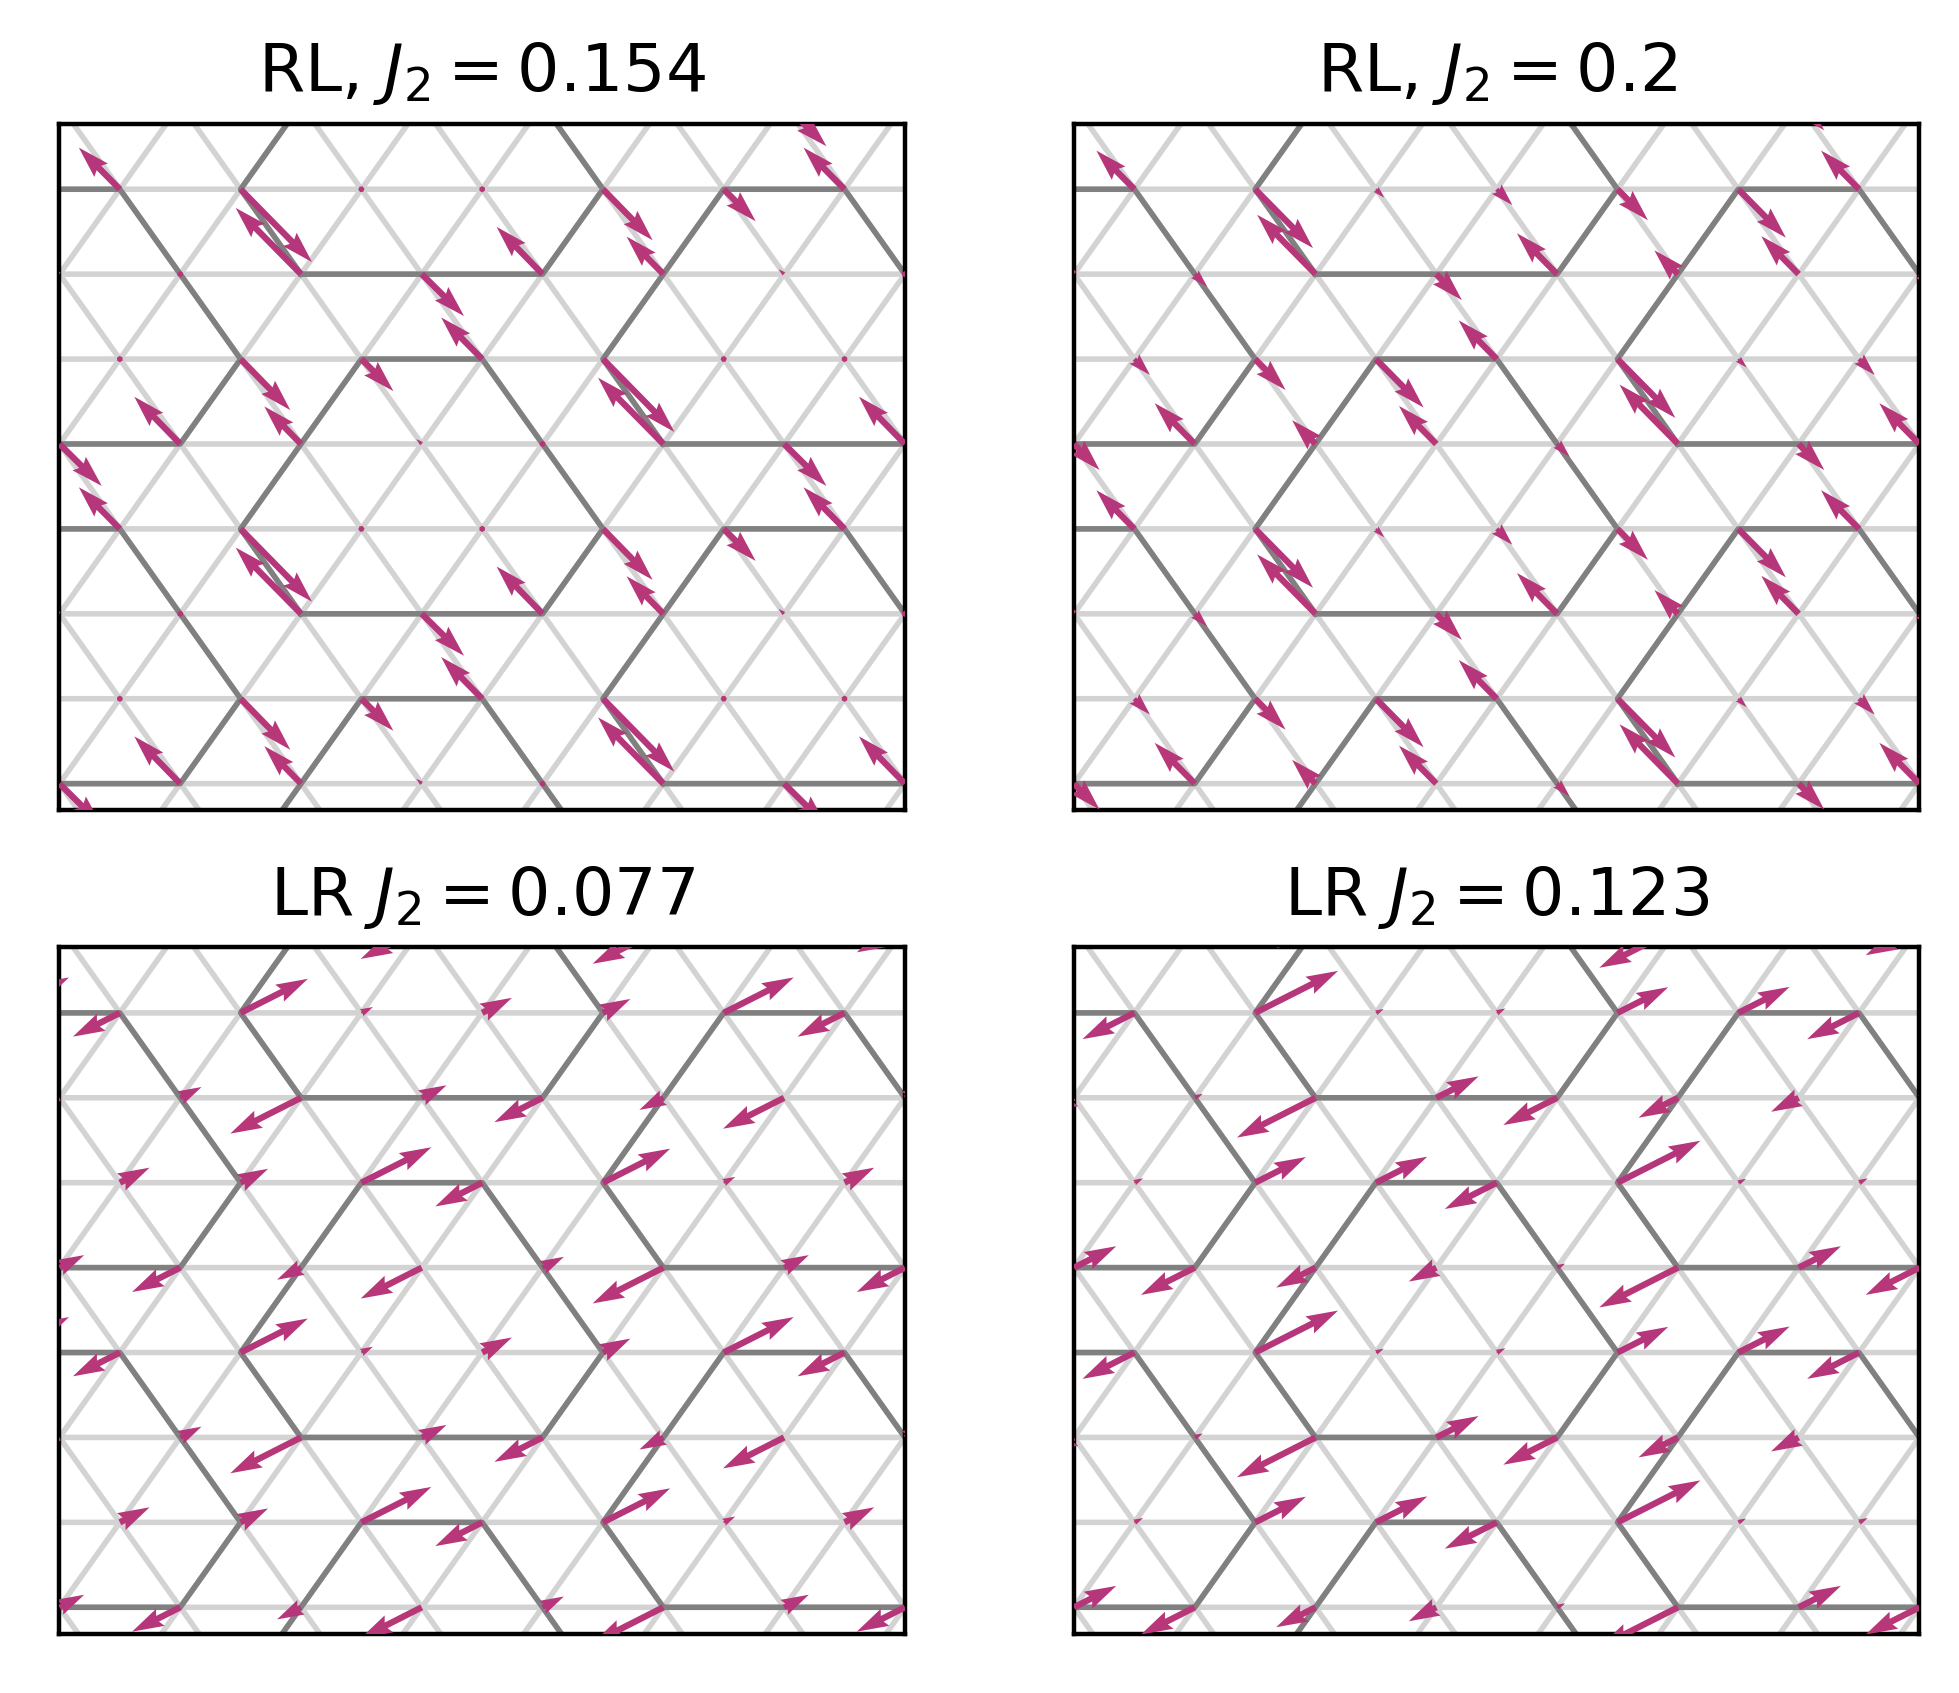

In [14]:
ind_1_rl = np.argmin(np.abs(J2s-.15))
ind_2_rl = np.argmin(np.abs(J2s-.2))
steps=49

plt.figure(figsize=(6,5), dpi=400)
az = .5*np.sqrt(3)

plt.subplot(2,2,1)
draw_tri_lattice((-3, -4*az), 10, 10)
r0s = [[0,0], plaq['vs'][0], plaq['vs'][1], -plaq['vs'][0], -plaq['vs'][1],
       plaq['vs'][1] + plaq['vs'][0], -plaq['vs'][1] - plaq['vs'][0],
       plaq['vs'][1] - plaq['vs'][0], -plaq['vs'][1] + plaq['vs'][0]
      ]
for r0 in r0s:
    draw_cluster(plaq, r0, color='gray')
    plot_spins(plaq, mfs['rl'][ind_1_rl], r0)
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.xticks([])
plt.yticks([])
plt.title(r'RL, $J_2 = {}$'.format(np.round(J2s[ind_1_rl], 3)))
print(energies['rl'][ind_1_rl])


plt.subplot(2,2,2)
draw_tri_lattice((-3, -4*az), 10, 10)
r0s = [[0,0], plaq['vs'][0], plaq['vs'][1], -plaq['vs'][0], -plaq['vs'][1],
       plaq['vs'][1] + plaq['vs'][0], -plaq['vs'][1] - plaq['vs'][0],
       plaq['vs'][1] - plaq['vs'][0], -plaq['vs'][1] + plaq['vs'][0]
      ]
for r0 in r0s:
    draw_cluster(plaq, r0, color='gray')
    plot_spins(plaq, mfs['rl'][ind_2_rl], r0)
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.xticks([])
plt.yticks([])
plt.title(r'RL, $J_2 = {}$'.format(np.round(J2s[ind_2_rl], 3)))
print(energies['rl'][ind_2_rl])



plt.subplot(2,2,3)
draw_tri_lattice((-3, -4*az), 10, 10)
r0s = [[0,0], plaq['vs'][0], plaq['vs'][1], -plaq['vs'][0], -plaq['vs'][1],
       plaq['vs'][1] + plaq['vs'][0], -plaq['vs'][1] - plaq['vs'][0],
       plaq['vs'][1] - plaq['vs'][0], -plaq['vs'][1] + plaq['vs'][0]
      ]
for r0 in r0s:
    draw_cluster(plaq, r0, color='gray')
    plot_spins(plaq, mfs['lr'][steps-ind_1_rl], r0)
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.xticks([])
plt.yticks([])
plt.title(r'LR $J_2 = {}$'.format(np.round(J2s[::-1][steps-ind_1_rl], 3)))
print(energies['lr'][steps-ind_1_rl])


plt.subplot(2,2,4)
draw_tri_lattice((-3, -4*az), 10, 10)
r0s = [[0,0], plaq['vs'][0], plaq['vs'][1], -plaq['vs'][0], -plaq['vs'][1],
       plaq['vs'][1] + plaq['vs'][0], -plaq['vs'][1] - plaq['vs'][0],
       plaq['vs'][1] - plaq['vs'][0], -plaq['vs'][1] + plaq['vs'][0]
      ]
for r0 in r0s:
    draw_cluster(plaq, r0, color='gray')
    plot_spins(plaq, mfs['lr'][steps-ind_2_rl], r0)
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.xticks([])
plt.yticks([])
plt.title(r'LR $J_2 = {}$'.format(np.round(J2s[::-1][steps-ind_2_rl], 3)))
print(energies['lr'][steps-ind_2_rl])

plt.show()